In [30]:
pip install jalali_pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import jalali_pandas
from datetime import datetime,date
import matplotlib.pyplot as plt


In [34]:
dollor = pd.read_excel('/content/drive/MyDrive/Marketcap Charts/dollor.xlsx')

In [35]:
Mcap =  pd.read_excel('/content/drive/MyDrive/Marketcap Charts/marketcap.xlsx')

In [13]:
dollor.rename(columns = {'تاریخ':'DATE', 'دلار':'dollorRate'}, inplace = True)
dollor['DATE'] = dollor['DATE'].str.replace('-','/')
dollor["DATE"] =dollor["DATE"].jalali.parse_jalali("%Y/%m/%d")
dollor["DATE"] = dollor["DATE"].jalali.to_gregorian()
Mcap.drop(['ClosePrice', 'last Capital'], axis=1,inplace=True)
Mcap.rename(columns = {'market cap':'MarketCap'}, inplace = True)
Mcap.drop(Mcap.index[Mcap['MarketCap'] == '#VALUE!'], inplace=True)
Mcap.MarketCap = pd.to_numeric(Mcap.MarketCap)
Mcap['DateTimeEn'] = pd.to_datetime(Mcap['DateTimeEn']).dt.date
Mcap['DateTimeEn'] = pd.to_datetime(Mcap['DateTimeEn'], format='%Y-%m-%d')
Mcap = Mcap.query(" DateTimeEn >= '2009-03-01'" )
mean_dollor = dollor.groupby(pd.PeriodIndex(dollor['DATE'], freq="M"))['dollorRate'].mean().reset_index()




In [26]:
saham_name = input("نماد سهام مورد نظر را وارد کنید")
saham = Mcap[Mcap['ShortName'] == saham_name ]

نماد سهام مورد نظر را وارد کنیددزهراوی


In [27]:
dollorratedict = dict()

for index, row in mean_dollor.iterrows():
    dollorratedict[row["DATE"].strftime("%b %Y")] = int(row["dollorRate"])


Marketcapdict = dict()

for index, row in saham.iterrows():
 
    Marketcapdict[row["DateTimeEn"].strftime("%b %Y")] = int(row["MarketCap"])


marketcappric_bydollor = []

for x, y in Marketcapdict.items():
    
    if x in dollorratedict.keys():
        marketcappric_bydollor.append([int(y/dollorratedict.get(x)),x])
        


In [28]:
Final = pd.DataFrame(marketcappric_bydollor, columns =['marketcappric_bydollor', 'DATE'])
Final["DATE"] = Final["DATE"].astype("datetime64[ns]")
Final

,marketcappric_bydollor,DATE
0,84743369,2009-03-01
1,102465097,2009-04-01
2,110865501,2009-05-01
3,104872859,2009-06-01
4,107854218,2009-07-01
...,...,...
156,52255458,2022-05-01
157,42813352,2022-06-01
158,34353720,2022-07-01
159,41870382,2022-08-01


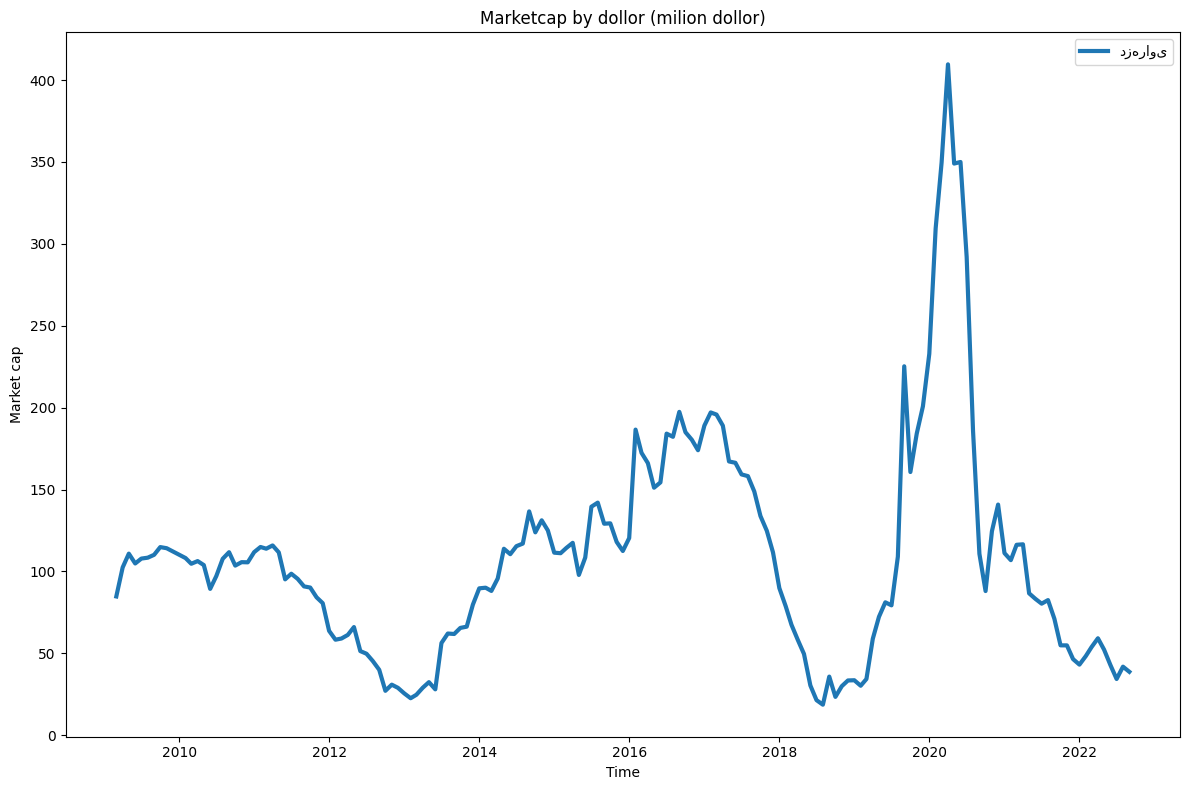

In [29]:
fig = plt.figure(figsize=(12, 8))
plt.plot(Final.DATE, Final.marketcappric_bydollor/1000000, label=saham_name, 
         linewidth=3)

# Add title and labels

plt.title('Marketcap by dollor (milion dollor)')
plt.xlabel('Time')
plt.ylabel('Market cap')

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot